In [22]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

In [23]:
rootfolder = '../'


Useful function for plot the dictionary

In [24]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

In [25]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  # residual
  r = s - np.dot(D, x)
  resNorm = np.linalg.norm(r)

  # support set
  omega = []
  while np.count_nonzero(x) < L and resNorm > tau: #STOPPING CRITERIA:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        zj = np.dot(r.T,D[:,j])/np.linalg.norm(D[:,j])**2
        e[j] = np.linalg.norm(r) - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x[omega] = np.dot(np.linalg.inv((D[:,omega].T @ D[:,omega])),D[:,omega].T @ s)

    # update the residual
    r = s - np.dot(D, x)
    resNorm = np.linalg.norm(r)


  return x

In [26]:
def soft_thresholding(x, lmbda):
    return np.sign(x) * np.maximum(np.abs(x) - lmbda, 0)

In [27]:
def FISTA(s, D, lmbda):

    ### Function to be minimized ###
    df = lambda x: D.T @ (D @ x - s)

    MAX_ITER = 1e3
    TOL_DIST_X = 1e-6
    # set the optimal value for alpha
    alpha = 1 / np.max(np.linalg.eigvals(D.T@D))
    
    # initialize x
    x = np.zeros(D.shape[1])

    # initialize y
    y = x

    # initialize gamma
    gamma = 1

    grad_norm = 1e10
    distanceX = 1e10

    # initialize the list with all the estimates
    all_x = [x]
    gamma_past = gamma

    cnt = 0
    while grad_norm > 1e-6 and distanceX > TOL_DIST_X and cnt < MAX_ITER:
        # compute the argument of the proximal operator
        x = y - alpha * df(y)

        # perform soft thresholding of x
        x = soft_thresholding(x, lmbda*alpha)

        # update gamma
        gamma_past = gamma
        gamma = (1 + np.sqrt(1 + 4 * gamma_past ** 2)) / 2

        # update y
        y = x + (gamma_past - 1) / gamma * (x - all_x[-1])

        # compute the stopping criteria
        #grad_norm = np.linalg.norm(df(x))
        distanceX = np.linalg.norm(x - all_x[-1])

        # store the estimate
        all_x.append(x)
    return x

Set all the paramters for the anomaly detection

In [28]:
# patch size (tha patch is square)
p = 15

# number of patches in the training set for dictionary learning
npatch_dictionary = 10000

# number of patches to estimate the confidence region
npatch_region = 1000

# paramters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

In [29]:
def get_random_patches(MPatchSize,nPatches, img):
    imsz = img.shape
    S = np.zeros((MPatchSize, nPatches))

    for i in range(nPatches):
        x = np.random.randint(0, imsz[0] - p)
        y = np.random.randint(0, imsz[1] - p)
        S[:, i] = img[x:x + p, y:y + p].flatten() 
    return S
    


In [30]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}/data/img_normal.png') / 255

# extract random patches from the image and store them in a matrices S, V
S = get_random_patches(p*p, npatch_dictionary, img)
V = get_random_patches(p*p, npatch_region, img)

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [31]:
# PREPROCESSING: exclude black patches from S
v = np.median(S, axis=0)
S = S[:,v > 0.06]

In [32]:
# PREPROCESSING: remove the mean from each patch
S -= np.mean(S, axis=0) 


Perform dictionary learning via KSVD or MOD

In [33]:
# D =

# or load a precomputed dictionary
D = loadmat(f'{rootfolder}/data/dict_anom_det.mat')['D']

Show the learned dictionary

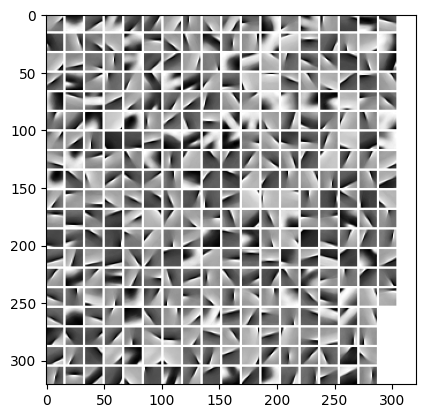

In [34]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [35]:
# PREPROCESSING: exclude black patches
v = np.median(V, axis=0)
V = V[:,v > 0.06]

In [36]:
# PREPROCESSING: remove the mean from each patch
V -= np.mean(V, axis=0)

In [37]:
# sparse coding of each patch in V
X = np.zeros((natom, npatch_region))
for i in tqdm(range(V.shape[1])):
    X[:, i] = FISTA(V[:, i], D, lmbda)



  0%|          | 0/943 [00:00<?, ?it/s]

/tmp/ipykernel_4846/445193322.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  X[:, i] = FISTA(V[:, i], D, lmbda)
100%|██████████| 943/943 [11:02<00:00,  1.42it/s]


In [38]:
V.shape[1]

943

In [39]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

A = np.zeros((2, V.shape[1]))     # each column contains the values of the anomaly_scores for a patch

for i in range(V.shape[1]):
    A[:,i] = [np.linalg.norm(V[:,i] - D @ X[:,i])**2, np.linalg.norm(X[:,i], 1)]

# Estimation of mean and covariance
mu = np.mean(A,axis = 1)
Sigma = np.cov(A)


In [40]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.1

# compute the mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
    mahal_dist[i] = (A[:,i] - mu).T @ np.linalg.inv(Sigma) @ (A[:,i] - mu)

# set the threshold
threshold = np.quantile(mahal_dist, 1-FPR_target)


## Test phase

In [41]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255

imsz = img_test.shape

STEP = 7
# initialize the estimated image
heatmap = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [42]:
for i in tqdm(range(0, imsz[0] - p + 1, STEP)):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img_test[i:i + p, j:j + p].reshape(-1)

        # if the median of s is to small set the anomaly score to 0:
        if np.median(s) <= 0.06:
            score = 0
        else:
            # subratct the mean to the patch
            s -= np.mean(s)

            # perform the sparse coding
            x = FISTA(s, D, lmbda)

            # compute the anomaly indicators vector
            a = np.array([np.linalg.norm(s - D @ x)**2, np.linalg.norm(x, 1)])

            # compute the anomaly score
            score = (a - mu).T @ np.linalg.inv(Sigma) @ (a - mu)

        # update the heatmap
        heatmap[i:i + p, j:j + p] += score

        # update the weight matrix
        weights[i:i + p, j:j + p] += 1


100%|██████████| 97/97 [2:29:55<00:00, 92.74s/it]  


In [43]:
# normalize the heatmap
heatmap /= weights

/tmp/ipykernel_4846/4266218129.py:2: RuntimeWarning: invalid value encountered in divide
  heatmap /= weights


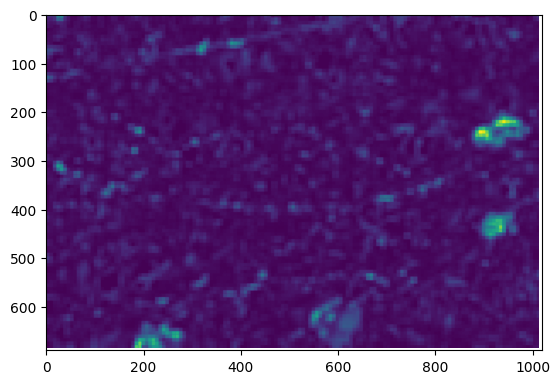

In [44]:
# plot the heatmap
plt.imshow(heatmap)

In [45]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = np.zeros_like(img_test)
mask = heatmap > threshold


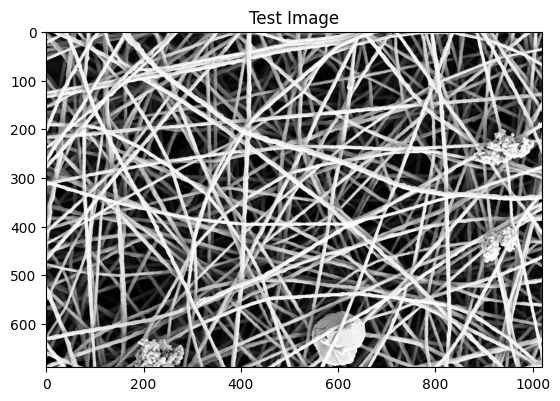

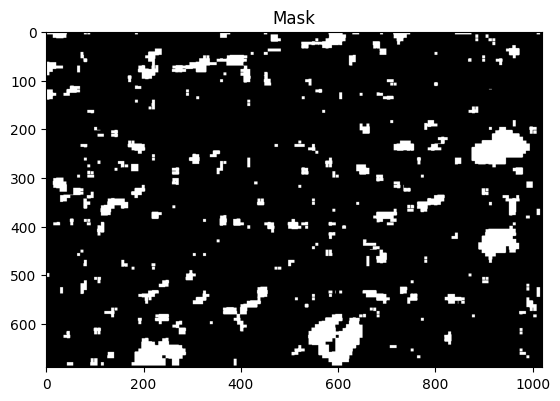

In [46]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

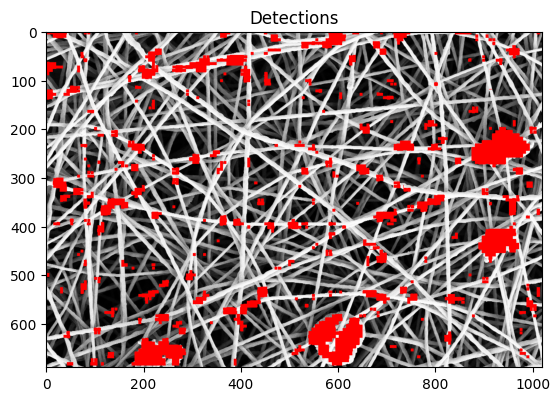

In [47]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,2] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()